<div style="text-align:center">
  <h1>Thesis Code Robustness Investigation</h1>
  <h3>Yannick van Etten (2688877)</h3>
  <h3>Master Econometrics and Operations Research</h3>
</div>

The aim of this thesis is to determine whether election results reflect the population’s sentiments on three key issues: "Environment", "Immigration", and "Economy". The estimation results are striking. An increase in the percentage of people who see an issue as the most prominent in these elections is not reflected by a significant increase in the election score with respect to the previous election for this issue. In this research, the data for the independent variables are derived from reliable sources. One less reliable data point is the party scores used in the construction of the dependent variable. While party ranking on issues is not controversial, the scores themselves are determined by conversations with friends and family. It is important to investigate whether this result is not solely determined by the distance between assigned party scores. The aim of the robustness investigation is to verify how different assigned party scores, based on the party ranking, influence the results.

<div style="text-align:center">
  <h4>Robustness Investigation Concept</h4>
</div>

The election issue score for issue $i$ are obtained by multiplying the party score vector, $S_\tau^i$, by the election result percentage $Z$ and summed for all parties. In this set up, previously, an issue score was derived for all parties. In theory, this means that the parties were ranked, and the issue difference between them was quantified on a scale of 0 to 10. The ranking is the least controversial part of this method. Generally speaking, it is logical that for the environment issue, the PvdA will outrank the PVV, where the rank for will indicate the performance of a party in sustaining the environment and dealing with climate change. Meanwhile, for the issue of immigration, the PVV will outrank the PvdA. Less obvious is how this rank is translated to a scale of 0 to 10. Will the PvdA get a 7 for the environment while the PVV gets a 3? Or should the relative distance be larger/smaller?

<div style="text-align:center">
  <h4>Party Ranking</h4>
</div>

The ranking of the major parties for the issues of "Environment", "Immigration", and "Economy" should indicate the party's ability to handle this specific issue. This time, only the major parties were ranked without assigning a score. The ranking result can be seen in Table \ref{tab:party_rankings_issues}. This ranking was not much subject to much discussion. The politically engaged people who were asked for their views were all consistent in their ranking.
| Rank | Environment | Immigration | Economy |
|------|-------------|-------------|---------|
| 1    | GL          | PVV         | VVD     |
| 2    | PvdA        | VVD         | CDA     |
| 3    | CDA         | CDA         | PvdA    |
| 4    | VVD         | PvdA        | PVV     |
| 5    | PVV         |             |         |

<div style="text-align:center">
  <h4>Party Grouping</h4>
</div>

The remaining parties will be linked to the main parties based on issue-related voting behavior. The Dutch Parliamentary Voting Dataset contains a record of parliamentary voting behavior in the Dutch Second Chamber since 1945 and was constructed in the
paper by Louwerse, Otjes, and Van Vonno, 2018. This dataset is used to calculate the percentage of voting similarity between the parties with respect to the three issue topics
on each of the three intervals t = 1: 1994–2005, t = 2: 2005–2014, and t = 3: 2014–2021. These intervals are similar to the assigned party scores of Section 3.1. Based on
the similarity percentages, the remaining parties are linked to the most similar major
party in each interval. The tables with results are in Appendix E of the thesis document.

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.linalg import cholesky
from scipy.stats import chi2
from IPython.display import display
from scipy.stats import t
from scipy.linalg import cholesky
from joblib import Parallel, delayed
import pyarrow.parquet as pq
import pyarrow as pa
from tqdm import tqdm
import os

In [3]:
party_rank_env_1 = [
    ['PVV','LPF'],                          #5
    ['VVD','LN'],                           #4
    ['CDA','SGP','CU','CD','LPF','AOV'],    #3
    ['PvdA','D66'],                         #2
    ['GL','SP']                             #1
]

party_rank_env_2 = [
    ['PVV','LPF','FvD','JA21'],
    ['VVD','LPF'],
    ['CDA','SGP'],
    ['PvdA','CU'],
    ['GL','D66','SP','PvdD','50PLUS']
]

party_rank_env_3 = [
    ['PVV','FvD','JA21'],
    ['VVD'],
    ['CDA','SGP','D66','CU','BBB'],
    ['PvdA','DENK','BIJ1'],
    ['GL','PvdD','Volt','50PLUS','SP']
]

party_rank_immi_1 = [
    ['PvdA','D66','GL','SP','CU'],
    ['CDA','SGP','LN','AOV'],
    ['VVD','CD','LPF'],
    ['PVV'] 
]

party_rank_immi_2 = [
    ['PvdA','D66','GL','SP','CU','PvdD','50PLUS'],
    ['CDA','LPF','SGP'],
    ['VVD'],
    ['PVV']
]

party_rank_immi_3 = [
    ['PvdA','GL','SP','PvdD','50PLUS','DENK','BIJ1','Volt'],
    ['CDA','SGP','D66','CU'],
    ['VVD','BBB'],
    ['PVV','FvD','JA21']
]

party_rank_econ_1 = [
    ['PVV'],
    ['PvdA','D66','GL','SP'],
    ['CDA','LPF','SGP','CU','AOV','CD'],
    ['VVD','LN']
]

party_rank_econ_2 = [
    ['PVV'],
    ['PvdA','D66','GL','SP','CU','PvdD'],
    ['CDA','SGP','50PLUS'],
    ['VVD','LPF']
]

party_rank_econ_3 = [
    ['PVV','FvD','JA21','BBB'],
    ['PvdA','GL','SP','PvdD','50PLUS','DENK','BIJ1','Volt'],
    ['CDA','D66','SGP','CU','50PLUS'],
    ['VVD']
]

<div style="text-align:center">
  <h4>Variable Set Up</h4>
  <h5>Target Independent Variables</h5>  
</div>

For all elections in this time interval, the DPES survey
includes responses to the question: "What is the most important issue facing the country?". This data is an indication of the population’s perception of the importance of
these issues. The aim is to explain the election issue scores using the percentages of people who consider a specific issue the most important. These percentages, denoted as $x_{1,t,i}$, represent the proportion of people who view issue $i$ as the most important in election $t$. Stacking the observations for all elections leads to the vector $x_{1,i}$, for all
three issues $i \in (1, 2, 3)$, representing the importance of issue $i$ across all elections.

<div style="text-align:center">
  <h5>Control Variables</h5>  
</div>

The issue importance percentage is the primary focus variable. Additionally, several control variables will be included to isolate changes in the dependent variable unrelated to the focus variable. The first control variable included is the consumer confidence indicator, which is measured monthly by Statistics Netherlands (CBS). This indicator provides insights into consumers’ confidence and perceptions regarding the developments of the Dutch economy and their own financial situation. For the consumer confidence
control variable, the indicator value of the election months will be utilized, denoted by $x_2$.

The second control variable to be utilized is the employment rate. This rate represents the unemployed labor force as a percentage of the total labor force, both employed and unemployed, and is measured by CBS. According to the  efinition provided by the International Labour Organization (ILO), individuals aged between 15 and 75 are considered unemployed if they do not have paid work, are actively  eeking employment, and are available for work. The data obtained from CBS are quarterly seasonally adjusted unemployment rates. The unemployment rate for the control variable will be based on the specific rate of the election year, denoted by $x_3$.

In the code below, the data is read and stored in a matrix called 'var_X'.

In [4]:
var_X = pd.read_csv('All_data//X_percent.csv')
var_X['Confidence'] = pd.read_csv('All_data//election_confi.csv', header=None)
var_X['Unemployment'] = pd.read_csv('All_data//election_unemp.csv', header=None)
var_X = var_X.drop(columns=['Housing', 'Employment','Healthcare','Education'])
var_X

,Environment,Immigration,Economy,Confidence,Unemployment
0,4.635762,25.662252,29.194260,-4,8.5
1,4.997620,10.756782,8.710138,33,5.1
2,9.491348,1.415836,1.678028,-9,4.1
3,11.565696,1.180173,8.418568,-29,5.4
4,2.287457,12.962257,11.056043,14,5.5
5,1.299756,8.895207,35.418359,-13,5.4
6,0.956938,5.203349,53.409091,-28,6.4
7,6.160991,20.681115,10.804954,26,5.9
8,19.233499,5.535841,4.045422,-14,4.2


<div style="text-align:center">
  <h5>Independent Variable</h5>  
</div>

To establish the issue score of an election, two sources are utilized: firstly, the national election results obtained from the Kiesraad, the authority overseeing all elections, and secondly, the score per party on these issues. This link enables the derivation of a score for each issue for every election. The party score will be a number between 0 and 10 and should indicate the party’s ability to handle this specific issue. For example, the party score for "Environment" should indicate the performance of a party in sustaining the environment and dealing with climate change.

The national election results will be denoted by $Z$, an $n \times m$ matrix where $n$ is the number of elections and $m$ is the number of political parties. Each row depicts the percentage result of all political parties. In the time interval between 1994 and 2021, 9 elections have taken place. The score per party per issue is denoted by $S_\tau^i$, an $m \times 1$ matrix, where $m$ represents the number of political parties for issue $i$. The score is determined for the intervals $\tau = 1$: 1994--2005, $\tau = 2$: 2005--2014, and $\tau = 3$: 2014--2021.

To derive an issue score for an election, the party score is multiplied by the election result percentage and summed for all parties. Note that the party score varies over time periods. To account for this variation, the matrix $I_{n}^{(t)}$ is utilized. This is an $n \times n$ identity matrix where the diagonal values are ones only for the rows representing elections in the interval where $S_\tau^i$ holds, otherwise, the diagonal value will be zero:
$$
    \textbf{y}_{i} =  I_{n}^{(1)} Z S_1^i + I_{n}^{(2)} Z S_2^i + I_{n}^{(3)} Z S_3^i
$$
where $\textbf{y}_{i}$ denotes the score for issue $i$ for all election years, in an $n \times 1$ matrix. It's important to note that the elections scores will always fall between $0$ and $10$. This is because the election percentages in $Z$ can be interpreted as weights that sum up to $100\%$, and the party scores in $S_\tau^i$ range between $0$ and $10$. For each of the three issues $i \in (1,2,3)$, a vector $\textbf{y}_{i}$ is obtained, leading to the matrix $Y = (\textbf{y}_{1}, \textbf{y}_{2}, \textbf{y}_{3})$.

Previously the party scores were determined by conversations with politically engaged persons. This time all possible party scores will be evaluated based on the ranking of the parties. The exact method will be developed later on.

<div style="text-align:center">
  <h4>Robustness Investigation Model</h4>
</div>

The estimation results from a restricted and unrestricted model were shown in the model estimation Notebook. The result section in the thesis concluded that the restricted model with $\gamma=1$ is reasonable. This model is also used in the robustness investigation. The model is given by:
$$
    \Delta \textbf{y}_i = \beta_{0} + \textbf{x}_{1,i} * \beta_{1,i} + \textbf{x}_{2} * \beta_{2} + \textbf{x}_{3} * \beta_{3} + \epsilon_i
$$
where $\textbf{y}_{i}$ denotes the score for issue $i$ for all election years. In this set up, an issue-dependent parameters exist. The parameter $\beta_{1,i}$ corresponding to the effect of the population issue percentage, as the relationship between the focus variable and the independent variable could vary for each issue. In this model, the control variable parameters are assumed to be consistent across different issues. To enhance the power of estimation, the three distinct linear models are merged into one by stacking the vectors of the dependent variable and structuring the $X$ matrix in a way that allows for the effect of the issue-specific focus variables to vary across all issues. This results in the following model: 
$$
    \text{vec}\Delta Y = X\beta + \text{vec}\epsilon
$$
where $\beta$ a $k\times 1$ vector, $\epsilon=(\epsilon_1,\epsilon_2,\epsilon_3)'$ and
\begin{align*}
\Delta Y &=(\Delta \textbf{y}_1, \Delta \textbf{y}_2,\Delta \textbf{y}_3)'\\
X &=
    \begin{pmatrix}
    \textbf{1} & \textbf{x}_{1,1} & \textbf{0}  & \textbf{0}  & \textbf{x}_{2} & \textbf{x}_{3} \\
    \textbf{1} & \textbf{0} & \textbf{x}_{1,2}& \textbf{0}  & \textbf{x}_{2} &\textbf{x}_{3} \\
    \textbf{1} & \textbf{0}  & \textbf{0} & \textbf{x}_{1,3} & \textbf{x}_{2} & \textbf{x}_{3} \\
    \end{pmatrix} 
\end{align*}

In [5]:
def create_X(var_X):
    vZero = np.zeros(len(var_X))
    vX = pd.DataFrame({'Environment':np.hstack((np.array(var_X['Environment']),vZero,vZero))})
    vX['Immigration'] = np.hstack((vZero,np.array(var_X['Immigration']),vZero))
    vX['Economy'] = np.hstack((vZero,vZero,np.array(var_X['Economy'])))
    vX['Consumer Confidence'] = np.hstack((var_X['Confidence'],var_X['Confidence'],var_X['Confidence']))
    vX['Unemployment Ratio'] = np.hstack((var_X['Unemployment'],var_X['Unemployment'],var_X['Unemployment']))
    return vX

In [6]:
var_X_new = var_X.iloc[1:,:]
vX = create_X(var_X_new)
vX = sm.add_constant(vX)
vX

,const,Environment,Immigration,Economy,Consumer Confidence,Unemployment Ratio
0,1.0,4.997620,0.000000,0.000000,33,5.1
1,1.0,9.491348,0.000000,0.000000,-9,4.1
2,1.0,11.565696,0.000000,0.000000,-29,5.4
3,1.0,2.287457,0.000000,0.000000,14,5.5
4,1.0,1.299756,0.000000,0.000000,-13,5.4
5,1.0,0.956938,0.000000,0.000000,-28,6.4
6,1.0,6.160991,0.000000,0.000000,26,5.9
7,1.0,19.233499,0.000000,0.000000,-14,4.2
8,1.0,0.000000,10.756782,0.000000,33,5.1
9,1.0,0.000000,1.415836,0.000000,-9,4.1


<div style="text-align:center">
  <h4>Estimation Method</h4>
</div>

In the linear equation $\epsilon = (\epsilon_1,\epsilon_2,\epsilon_3)'$, where the disturbances $\epsilon_i$ are denoted by a $n \times 1$ vector. The assumption of $\epsilon|X \sim N(0,\sigma^2I_{3n})$ needs to be evaluated. This likely this does not hold due to interdependence of the issues, so $\hat{\beta}^{ols}$ is not efficient anymore. Therefore, we assume $\epsilon|X \sim N(0,\Omega)$. One method to deal with this situation is Generalized Least Squares (GLS), where the idea is to find $P$ such that $P'P=\Omega^{-1}$. The data can be transformed by $Py=PX\beta + Pu$. The errors of this model fulfill the Gauss Markov assumptions again, resulting in: 
$$
    \hat{\beta}^{GLS} = (X'\Omega^{-1}X)^{-1}X'\Omega^{-1}Y
$$
It is essential to define a proper structure for $\Omega$, in order to use GLS. $\Omega$ is a $3n \times 3n$ symmetric matrix. In the previous setting:
$$
    \Omega = \sigma^2 I_{3n}
$$
where the error term is assumed to be homoscedastic, independent across issues, and uncorrelated across observations and over time. However, it is reasonable to assume there are correlations between issues, and this needs to be captured in the covariance matrix. This can be accomplished by changing the structure of the covariance matrix as follows:
$$
    \Omega = \sigma^2     \begin{pmatrix}
    1 & \rho_{12}  & \rho_{13}  \\
    \rho_{12} & 1& \rho_{23}  \\
    \rho_{13}  & \rho_{23} & 1  \\
    \end{pmatrix}  
    \otimes I_{3n}
$$
where $\rho_{ij}$ denotes the correlation between issue $i$ and issue $j$ and $\sigma^2$ the variance of the residuals across all issues and elections. The Kronecker product creates a block diagonal structure so the issue correlations are repeated over time for each election. These $\rho_{ij}$ values are estimated by the correlation of the residuals of each issue, determined by the \acrshort{ols} estimation. So $\rho_{ij} = \text{corr}(e_i,e_j)$.  After obtaining these estimates, it is possible to perform the GLS estimation, where the non-zero off-diagonal elements in $\Omega$ indicate that the disturbances for different issues are correlated. GLS is repeated over and over again till the $\beta$ estimates are converged. The $\Omega$ matrix is estimated by the correlation $\rho_{ij}$ between issue $i$ and issue $j$. These are obtained using the residuals from the previous GLS step. This procedure is known as Iterated Generalized Least Squares (iGLS). 

The code below shows the OLS, estimation function, keep in mind that GLS is equal to OLS on the transformed data by $Py=PX\beta + Pu$.

In [7]:
def OLS(X, vY, XtX_inv):
    beta_hat = XtX_inv @ X.T @ vY
    e = vY - X @ beta_hat
    s = (e.T @ e) / (X.shape[0] - X.shape[1])
    sd = np.sqrt(np.diag(s * XtX_inv))
    t_stat = beta_hat / sd
    return beta_hat, e, s, sd, t_stat

<div style="text-align:center">
  <h4>Robustness Investigation Implementation</h4>
</div>

Given this setup, it is possible to implement the Robustness Investigation. The first step is to determine all possible party scores, given the party ranking on the three issues. The realised party scores are not time-varying, however the remaining parties are linked to the main parties in each different interval. When 4 parties are ranked on a interval between 0 and 10, with one unit distance, this leads $\binom{11}{4} = 330$ different election scores for each issue. When 5 parties are ranked this leads to $\binom{11}{5} = 462$ different party scores. The 5 groups are ranked with respect to "Environment", for the other two issues, 4 groups are ranked.

In [8]:
def generate_ranked_numbers(num_numbers, current_numbers=None):
    if current_numbers is None:
        current_numbers = []
    if len(current_numbers) == num_numbers:
        return [current_numbers]
    results = []
    start = 0 if not current_numbers else current_numbers[-1] + 1
    for num in range(start, 11 - num_numbers + len(current_numbers) + 1):
        next_numbers = current_numbers + [num]
        results.extend(generate_ranked_numbers(num_numbers, next_numbers))
    return results

In [9]:
possible_scores_4_parties = generate_ranked_numbers(4) # based on 1.0 increases
possible_scores_5_parties = generate_ranked_numbers(5) # based on 1.0 increases

<div style="text-align:center">
  <h5>Elections Results</h5>
</div>

The official election outcome is given by:

In [10]:
df_official_results = {
                #1994   1998    2002    2003    2006    2010    2012    2017    2021
    'VVD':      [19.96, 24.69,  15.44,  17.91,  14.67,  20.49,  26.58,  21.29,  21.87],
    'PvdA':     [23.97, 28.98,  15.11,  27.26,  21.19,  19.63,  24.84,  5.7,    5.73],
    'CDA':      [22.23, 18.37,  27.93,  28.62,  26.51,  13.61,  8.51,   12.38,  9.5],
    'PVV':      [None,  None,   None,   None,   5.89,   15.45,  10.08,  13.06,  10.79],
    'D66':      [15.49, 8.99,   5.1,    4.07,   1.96,   6.95,   8.03,   12.23,  15.02],
    'SP':       [1.32,  3.53,   5.9,    6.32,   16.58,  9.82,   9.65,   9.09,   5.98],
    'GL':       [3.47,  7.27,   6.95,   5.14,   4.6,    6.67,   2.33,   9.13,   5.16],
    'CU':       [3.10,  3.29,   2.54,   2.12,   3.97,   3.24,   3.13,   3.39,   3.37], # first 2 rpf + gpv
    'SGP':      [1.73,  1.78,   1.72,   1.56,   1.56,   1.74,   2.09,   2.08,   2.07],
    'PvdD':     [None,  None,   None,   0.49,   1.83,   1.3,    1.93,   3.19,   3.84],
    'LPF':      [None,  None,   17,     5.7,    None,   None,   None,   None,   None],
    'FvD':      [None,  None,   None,   None,   None,   None,   None,   1.78,   5.02],
    '50PLUS':   [None,  None,   None,   None,   None,   None,   1.88,   3.11,   1.02],
    'DENK':     [None,  None,   None,   None,   None,   None,   None,   2.06,   2.03],
    'Volt':     [None,  None,   None,   None,   None,   None,   None,   None,   2.42],
    'JA21':     [None,  None,   None,   None,   None,   None,   None,   None,   2.37],
    'BBB':      [None,  None,   None,   None,   None,   None,   None,   None,   1],
    'BIJ1':     [None,  None,   None,   None,   None,   None,   None,   None,   0.84],
    'AOV':      [3.63,  None,   None,   None,   None,   None,   None,   None,   None],
    'CD':       [2.46,  0.61,   None,   None,   None,   None,   None,   None,   None],
    'LN':       [None,  None,   1.61,   0.4,    None,   None,   None,   None,   None]
}

In [11]:
election_years = [1994, 1998, 2002, 2003, 2006, 2010, 2012, 2017, 2021]
df_official = pd.DataFrame.from_dict(df_official_results, orient='index', columns=election_years)
df_official = df_official.fillna(0)
df_official = df_official.T
df_official = df_official.apply(lambda x: 100 * x / x.sum(), axis=1)
df_official

,VVD,PvdA,CDA,PVV,D66,SP,GL,CU,SGP,PvdD,...,FvD,50PLUS,DENK,Volt,JA21,BBB,BIJ1,AOV,CD,LN
1994,20.501233,24.619967,22.832786,0.000000,15.910025,1.355793,3.564092,3.184059,1.776910,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.728431,2.526705,0.000000
1998,25.320480,29.720029,18.839093,0.000000,9.219567,3.620142,7.455646,3.374013,1.825454,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.625577,0.000000
2002,15.548842,15.216516,28.126888,0.000000,5.135952,5.941591,6.998993,2.557905,1.732125,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.621349
2003,17.983733,27.372226,28.737825,0.000000,4.086756,6.346019,5.161161,2.128728,1.566422,0.492017,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.401647
2006,14.854192,21.456055,26.842851,5.963953,1.984609,16.788173,4.657756,4.019846,1.579587,1.852977,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010,20.717897,19.848332,13.761375,15.621840,7.027300,9.929221,6.744186,3.276036,1.759353,1.314459,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2012,26.834932,25.078243,8.591620,10.176678,8.107017,9.742554,2.352347,3.160020,2.110045,1.948511,...,0.000000,1.898031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017,21.616408,5.787390,12.569804,13.260229,12.417504,9.229363,9.269977,3.441974,2.111890,3.238908,...,1.807290,3.157681,2.091583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021,22.309497,5.845149,9.690911,11.006835,15.321840,6.100173,5.263695,3.437723,2.111598,3.917168,...,5.120881,1.040498,2.070795,2.468632,2.417627,1.020096,0.856881,0.000000,0.000000,0.000000


<div style="text-align:center">
  <h5>Elections Scores</h5>
</div>

All possible election scores are calculated using these the matrix with all possible party scores and the election results. Recall that in order to derive an issue score for an election, the party score is multiplied by the election result percentage and summed for all parties. To account for this variation, the matrix $I_{n}^{(t)}$ is utilized. This is an $n \times n$ identity matrix where the diagonal values are ones only for the rows representing elections in the interval where $S_\tau^i$ holds, otherwise, the diagonal value will be zero:
$$
    \textbf{y}_{i} =  I_{n}^{(1)} Z S_1^i + I_{n}^{(2)} Z S_2^i + I_{n}^{(3)} Z S_3^i
$$
where $\textbf{y}_{i}$ denotes the score for issue $i$ for all election years, in an $n \times 1$ matrix. It's important to note that the elections scores will always fall between $0$ and $10$. For each of the three issues $i \in (1,2,3)$, a vector $\textbf{y}_{i}$ is obtained, leading to the matrix $Y = (\textbf{y}_{1}, \textbf{y}_{2}, \textbf{y}_{3})$.

In the code below, $\Delta y$ is directly simulated, instead of $y$

In [12]:
def identity_zero(n,start,end):
    matrix = np.zeros((n, n))    
    for i in range(start, end):
        matrix[i,i] =  1
    return matrix

def calc_score(df_official,df_score):
    S1 = df_score["94-03"]
    S2 = df_score["06-12"]
    S3 = df_score["17-21"]

    df_official = df_official/100
    n = len(df_official)
    m = len(df_official.iloc[1,:])
    T1 = identity_zero(n,0,4)
    T2 = identity_zero(n,4,7)
    T3 = identity_zero(n,7,n)

    test1 = T1 @ df_official @ S1
    test2 = T2 @ df_official @ S2
    test3 = T3 @ df_official @ S3

    total_score = test1 + test2 + test3
    return total_score

In [13]:
def fill_parties(df,parties,rank,interval):
    for party in parties:
        if party in df.index:
            df.at[party,interval] = rank
    return df

def create_envir_df_sim(df_official,score,df_score):
    for j in range(3):
        for i in range(len(party_rank_env_1)):
            if j == 0:
                df_score = fill_parties(df_score,party_rank_env_1[i],score[i],'94-03')
            elif j == 1:
                df_score = fill_parties(df_score,party_rank_env_2[i],score[i],'06-12')
            elif j == 2:
                df_score = fill_parties(df_score,party_rank_env_3[i],score[i],'17-21')
    election_environ = calc_score(df_official,df_score)
    return election_environ

def create_immi_df_sim(df_official,score,df_score):
    for j in range(3):
        for i in range(len(party_rank_immi_1)):
            if j == 0:
                df_score = fill_parties(df_score,party_rank_immi_1[i],score[i],'94-03')
            elif j == 1:
                df_score = fill_parties(df_score,party_rank_immi_2[i],score[i],'06-12')
            elif j == 2:
                df_score = fill_parties(df_score,party_rank_immi_3[i],score[i],'17-21')
    election_immi = calc_score(df_official,df_score)
    return election_immi

def create_econ_df_sim(df_official,score,df_score):
    for j in range(3):
        for i in range(len(party_rank_econ_1)):
            if j == 0:
                df_score = fill_parties(df_score,party_rank_econ_1[i],score[i],'94-03')
            elif j == 1:
                df_score = fill_parties(df_score,party_rank_econ_2[i],score[i],'06-12')
            elif j == 2:
                df_score = fill_parties(df_score,party_rank_econ_3[i],score[i],'17-21')
    election_econ = calc_score(df_official,df_score)
    return election_econ

In [14]:
election_block = ["94-03",  "06-12",  "17-21"]
df_score_template = pd.DataFrame(0, index=df_official.columns, columns=election_block)
df_score = df_score_template.copy()
df_score[:] = 0

environment_all = np.zeros((len(possible_scores_5_parties), len(df_official)-1))
immigration_all = np.zeros((len(possible_scores_4_parties), len(df_official)-1))
economy_all = np.zeros((len(possible_scores_4_parties), len(df_official)-1))

for i in range(len(possible_scores_5_parties)):
    election_environ = create_envir_df_sim(df_official,possible_scores_5_parties[i],df_score)
    environment_all[i] = np.diff(election_environ)

for i in range(len(possible_scores_4_parties)):
    election_immi = create_immi_df_sim(df_official,possible_scores_4_parties[i],df_score)
    election_econ = create_econ_df_sim(df_official,possible_scores_4_parties[i],df_score) 
    immigration_all[i] = np.diff(election_immi)
    economy_all[i] = np.diff(election_econ)

print(len(environment_all))
print(len(immigration_all))
print(len(economy_all))

462
330
330


<div style="text-align:center">
  <h5>Dependent Variables</h5>
</div>

This is the last ingredient that is necessary for the Robustness Investigation. 

In [15]:
def calculate_betas(env_val, immi_val, econ_val, X, XtX_inv, nn, identity_n):
    Y = np.column_stack([env_val, immi_val, econ_val])
    vY = np.hstack(Y.T)

    beta_hat, e, s, sd, t_stat = OLS(X, vY, XtX_inv)
    residuals_matrix = e.reshape((-1, nn)).T
    correlation_matrix = np.corrcoef(residuals_matrix, rowvar=False)
    cs_block = correlation_matrix * s
    Omega = np.kron(cs_block, identity_n)
    P = cholesky(Omega, lower=True)
    P_inv = np.linalg.inv(P)
    X_transformed = P_inv @ X
    vY_transformed = P_inv @ vY
    beta_hat_gls, e, s, sd, t_stat_gls = OLS(X_transformed, vY_transformed, np.linalg.inv(X_transformed.T @ X_transformed))
    return np.round(beta_hat_gls, 5), np.round(t_stat_gls, 5)

def iteration_analysis(env, immi, econ, vX,Y):
    Y = Y.T
    X = np.array(vX)
    nn = 8
    identity_n = np.eye(nn)
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    betas_env = []
    betas_immi = []
    betas_econ = []
    tstat_env = []
    tstat_immi = []
    tstat_econ = []
    for i in range(len(env)):
        beta, tstat = calculate_betas(env[i], Y[1], Y[2], X, XtX_inv, nn, identity_n)
        betas_env.append(beta)
        tstat_env.append(tstat)
    for j in range(len(immi)):
        beta, tstat = calculate_betas(Y[0], immi[j], Y[2], X, XtX_inv, nn, identity_n) 
        betas_immi.append(beta)
        tstat_immi.append(tstat)
    for k in range(len(econ)):
        beta, tstat = calculate_betas(Y[0], Y[1], econ[k], X, XtX_inv, nn, identity_n)
        betas_econ.append(beta)
        tstat_econ.append(tstat)
    return np.vstack(betas_env), np.vstack(tstat_env), np.vstack(betas_immi), np.vstack(tstat_immi), np.vstack(betas_econ), np.vstack(tstat_econ)

In [16]:
vY_new = np.array(pd.read_csv('All_data//vY_new.csv',header=None))
Y = vY_new.reshape((-1, 8)).T
betas_env, tstat_env, betas_immi, tstat_immi, betas_econ, tstat_econ = iteration_analysis(environment_all,immigration_all,economy_all, vX,Y)

<div style="text-align:center">
  <h4>Robustness Evaluation</h4>
</div>

Tt becomes possible to evestigate the influence of the different party scores on the estimation results. The different dependent variables were calculated by the previous functions. This section investigate the different beta and $t$-statistic values for the three issues seperately. An interpretation is found in the thesis document.

<div style="text-align:center">
  <h5>Environment Evaluation</h5>
</div>

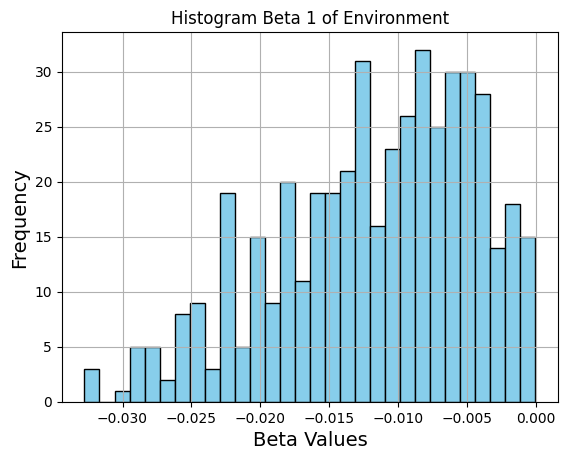

In [17]:
plt.hist(betas_env[:,1], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram Beta 1 of Environment')
plt.xlabel('Beta Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

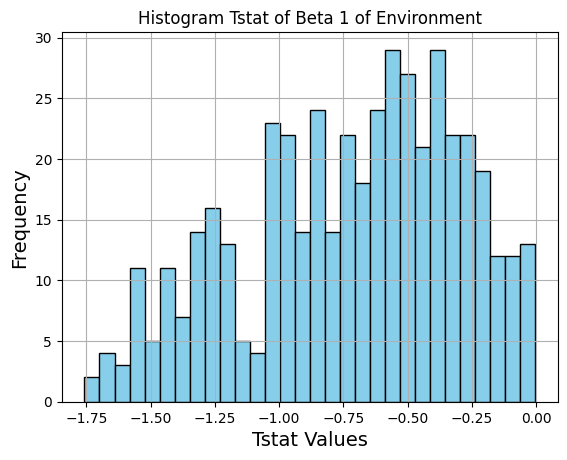

In [18]:
plt.hist(tstat_env[:,1], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram Tstat of Beta 1 of Environment')
plt.xlabel('Tstat Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

<div style="text-align:center">
  <h5>Immigation Evaluation</h5>
</div>

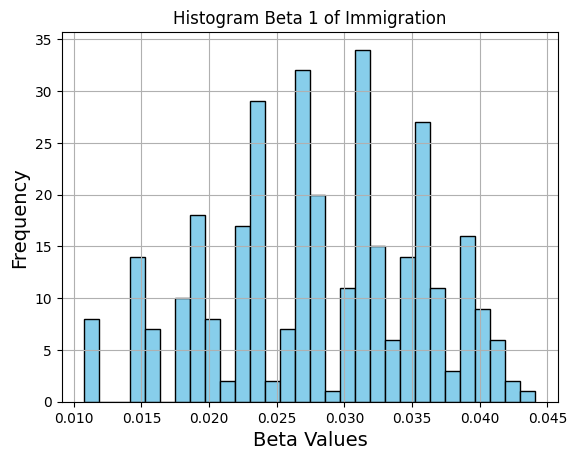

In [19]:
plt.hist(betas_immi[:,2], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram Beta 1 of Immigration')
plt.xlabel('Beta Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

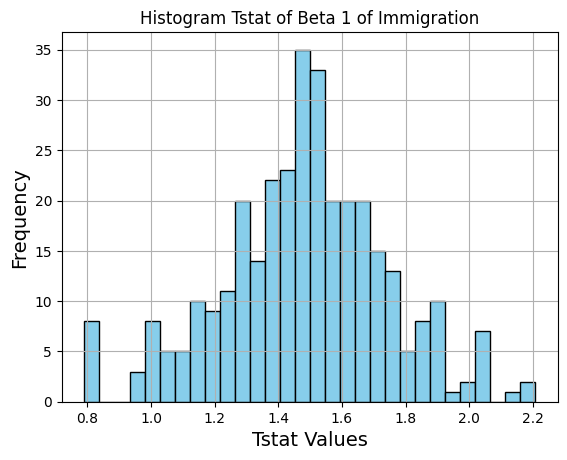

In [20]:
plt.hist(tstat_immi[:,2], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram Tstat of Beta 1 of Immigration')
plt.xlabel('Tstat Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

<div style="text-align:center">
  <h5>Economy Evaluation</h5>
</div>

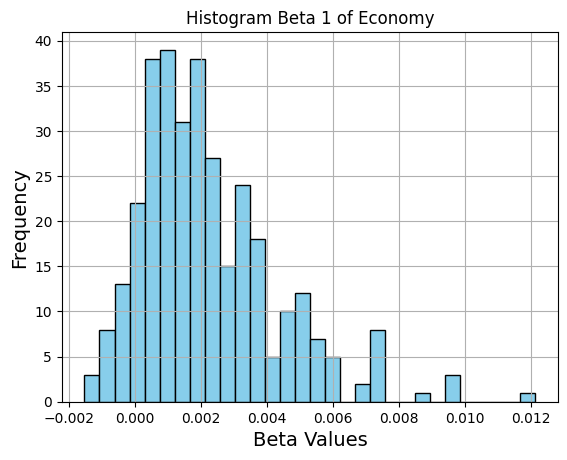

In [21]:
plt.hist(betas_econ[:,3], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram Beta 1 of Economy')
plt.xlabel('Beta Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

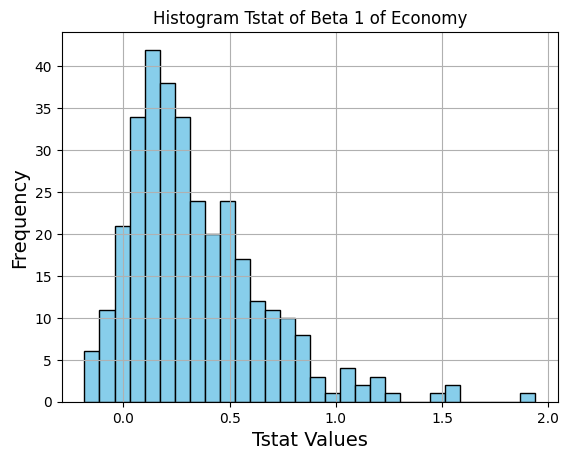

In [22]:
plt.hist(tstat_econ[:,3], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram Tstat of Beta 1 of Economy')
plt.xlabel('Tstat Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()


<div style="text-align:center">
  <h5>Significance check</h5>
</div>

In [23]:
numb_sig_env = sum(np.abs(tstat_env[:,1]) > 2.11 )
numb_sig_immi =sum(np.abs(tstat_immi[:,2]) > 2.11) 
numb_sig_econ = sum(np.abs(tstat_econ[:,3]) > 2.11 )

display(numb_sig_env) 
display(numb_sig_immi) 
display(numb_sig_econ) 

0

3

0